### Applying Machine Learning to Stock Investments: Data Clustering for S&P500 data

Machine Learning is broadly divided into supervised learning and unsupervised learning, and clustering is classified as unsupervised learning. Data clustering can be used effectively and practically in a variety of situations, such as dividing sales data into groups to reveal customer purchasing trends or dividing network data into groups to analyze communication patterns. Data clustering is also useful for identifying anonyous data.

In this tutorial, we will use historical data on stocks in the S&P500 to cluster stocks based on their stock price performance and analyze what patterns of fluctuation they have had. 

We can learn:

1. How to cluster data with different dimensionality (1-D, 2-D, 3-D and 20-D)?
2. How to understand the distribution of data with different number of dimensions.
3. How to interpret clustering results?

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Data Science WorkSpace/Data Science Tutorials/Data Clustering for Stock Data')

In [ ]:
!pip install yfinance >/dev/null

In [ ]:
import glob
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from concurrent import futures
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
#import pandas_datareader.data as web
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

data_dir = './data/stock_data_for_clustering'
os.makedirs(data_dir, exist_ok = True)

### Download Dataset (concurrent processing)

Pandas has a read_html method that can read table data from a web page. In this example, we will use the read_html method to retrieve information about the S&P500 from Wikipedia. There are two tables in the wiki page; S&P500 component stocks and selected changes to the list of S&P500 components. 

In [ ]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = tables[0]
print(first_table.shape)

(503, 9)


In [ ]:
first_table["Symbol"] = first_table["Symbol"].map(lambda x: x.replace(".", "-")) # rename symbol to escape symbol error
first_table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [ ]:
sp500_tickers = list(first_table['Symbol'])
print(sp500_tickers[:5])

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD']


Download historical price data for each stock in the S&P500 from yahoo finance. This time, we will download data for about two years,
from December 1st, 2021 to March 1st, 2022. 

In [ ]:
# def download_stock(stock):
#     try:
#         print(stock)
#         stock_df = web.DataReader(stock,'yahoo', start_time, end_time)
#         stock_df['Name'] = stock
#         output_name = f"{data_dir}/{stock}.csv"
#         stock_df.to_csv(output_name)
#     except:
#         bad_names.append(stock)
#         print('bad: %s' % (stock))

# """ set the download window """
# start_time = dt.datetime(2021, 12, 1)
# end_time = dt.datetime(2022, 3, 1)
# bad_names =[] #to keep track of failed queries
# #set the maximum thread number
# max_workers = 20
# now = dt.datetime.now()

# workers = min(max_workers, len(sp500_tickers)) #in case a smaller number of stocks than threads was passed in

# with futures.ThreadPoolExecutor(workers) as executor:
#     res = executor.map(download_stock, sp500_tickers)

# """ Save failed queries to a text file to retry """
# if len(bad_names) > 0:
#     with open(f'{data_dir}/failed_queries.txt','w') as outfile:
#         for name in bad_names:
#             outfile.write(name+'\n')
            
# finish_time = dt.datetime.now()
# duration = finish_time - now
# minutes, seconds = divmod(duration.seconds, 60)
# print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
# print(f"{len(bad_names)} stocks failed: ", bad_names)

In [ ]:
def download_stock(stock):
    try:
        stock_df = yf.download(stock, start_time, end_time)
        stock_df['Name'] = stock
        output_name = f"{data_dir}/{stock}.csv"
        stock_df.to_csv(output_name)
        print('success: %s' % (stock))
    except:
        bad_names.append(stock)
        print('bad: %s' % (stock))
        
# Set the download window
start_time = dt.datetime(2021, 12, 1)
end_time = dt.datetime(2022, 3, 1)

bad_names = [] # to keep track of failed queries 

# Set maximum thread number
#max_workers = 20

now = dt.datetime.now()

#workers = min(max_workers, len(sp500_tickers)) # in case a smaller number of stocks than threads was passed in

for stock in sp500_tickers:
    download_stock(stock)
        
# with futures.ThreadPoolExecutor(workers) as executor:
#     res = executor.map(download_stock, sp500_tickers)

# Save failed queries to a text file to retry later
if len(bad_names) > 0:
    with open(f'{data_dir}/failed_queries.txt', 'w') as outfile:
        for name in bad_names:
            outfile.write(name+'\n')
finish_time = dt.datetime.now()
duration = finish_time - now
minutes, seconds = divmod(duration.seconds, 60)
print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
print(f'{len(bad_names)} stocks failed:', bad_names)

[*********************100%***********************]  1 of 1 completed
success: MMM
[*********************100%***********************]  1 of 1 completed
success: AOS
[*********************100%***********************]  1 of 1 completed
success: ABT
[*********************100%***********************]  1 of 1 completed
success: ABBV
[*********************100%***********************]  1 of 1 completed
success: ABMD
[*********************100%***********************]  1 of 1 completed
success: ACN
[*********************100%***********************]  1 of 1 completed
success: ATVI
[*********************100%***********************]  1 of 1 completed
success: ADM
[*********************100%***********************]  1 of 1 completed
success: ADBE
[*********************100%***********************]  1 of 1 completed
success: ADP
[*********************100%***********************]  1 of 1 completed
success: AAP
[*********************100%***********************]  1 of 1 completed
success: AES
[***********

### Preprocessing Data

We are going to create 3 types of data.

1. Monthly stock price performance (%) in January 2022.
2. Bi weekly stock price performance (%) in January 2022.
3. Daily stock price performance (%) in January 2022.

In all case, the performance is calculated based on last trending day in 2021.

Each of these data has a different number of dimensions. Type 1 data has 1 dimension, type 2 has 3 dimensions (beginning, middle and end of January), and Type 3 has 20 dimensions. 

In [ ]:
historical_stock_data_files = glob.glob(f"./{data_dir}/*.csv")
reference_day = "2021-12-31"
start_day = "2022-01-03"
midterm_day = "2022-01-18"
end_day = "2022-01-31"
price_change_list = []
tickers_to_ignore = []

for files in historical_stock_data_files:
    df = pd.read_csv(files, index_col = ["Date"])
    ticker = os.path.splitext(os.path.basename(files))[0]
    try:
        price_close = df[reference_day: end_day][["Close"]]
        price_change = (price_close / price_close.loc[reference_day, "Close"] - 1) * 100
        price_change = price_change.iloc[1:, :]
        price_change = price_change.rename(columns={"Close":ticker})
        price_change_list.append(price_change)
    except KeyError as e:
        # some stocks started trading after 2021-12-31
        print(ticker)
        tickers_to_ignore.append(ticker)
        
df = pd.concat(price_change_list, axis=1)
print(df.shape)
df.head()

CEG
(20, 502)


,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.061927,-2.655794,-1.207910,0.014774,1.982347,-1.770594,1.337741,0.443857,-0.474377,-1.042261,...,-0.808454,-1.551401,3.210249,0.354513,-2.526683,-1.677950,-1.898519,1.645153,1.709940,-4.097857
2022-01-04,1.463712,-1.036691,-3.531335,-0.177245,0.673771,-2.472561,1.007062,2.308042,-2.303107,-0.579937,...,0.496860,0.430299,2.880994,0.989669,-1.492663,-1.152244,-1.276888,2.676323,4.607346,-7.749049
2022-01-05,1.047121,-2.690737,-3.964759,0.347121,-5.838461,-4.190085,-0.360736,1.509105,-9.281206,-1.427530,...,-0.202118,-1.908379,-0.928976,1.979326,-2.835225,-2.405298,-6.219761,2.337850,4.844841,-11.256813
2022-01-06,0.208295,-2.038439,-3.978972,-0.125553,-6.328482,-8.816787,-4.073349,2.411607,-9.335873,-2.104795,...,-1.326375,-1.564909,-0.470369,1.181688,-2.968644,-1.397092,-6.727157,1.487722,9.151366,-10.904397
2022-01-07,1.306081,-3.145017,-3.680551,-0.384039,-11.106165,-10.565671,-3.742669,3.284512,-9.938981,-3.138943,...,-2.496951,-2.431301,-0.576197,2.067949,-3.744161,-2.527722,-10.809816,0.873738,10.972129,-13.498341


In [ ]:
# Now all the data is ready
data_1 = df.loc[[end_day], :]
display(data_1.head())

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,-6.536058,-10.984275,-9.435843,1.100447,-17.623971,-14.707515,18.75846,10.963166,-5.777168,-16.388192,...,-1.486378,-4.463184,0.482121,2.895136,-12.424951,-9.858852,-14.462368,-3.16436,7.378087,-18.128921


In [ ]:
data_2 = df.loc[[start_day, midterm_day, end_day], :]
display(data_2.head())

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.061927,-2.655794,-1.207910,0.014774,1.982347,-1.770594,1.337741,0.443857,-0.474377,-1.042261,...,-0.808454,-1.551401,3.210249,0.354513,-2.526683,-1.677950,-1.898519,1.645153,1.709940,-4.097857
2022-01-18,0.365926,-6.045422,-10.068215,1.019206,-18.595653,-15.986007,23.718622,5.444593,-9.473419,-8.167734,...,-4.349657,-2.201683,7.114294,1.019206,-8.288855,-8.987472,-13.185491,-0.543133,9.927170,-16.936443
2022-01-31,-6.536058,-10.984275,-9.435843,1.100447,-17.623971,-14.707515,18.758460,10.963166,-5.777168,-16.388192,...,-1.486378,-4.463184,0.482121,2.895136,-12.424951,-9.858852,-14.462368,-3.164360,7.378087,-18.128921


In [ ]:
data_3 = df
display(data_3.head())

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.061927,-2.655794,-1.207910,0.014774,1.982347,-1.770594,1.337741,0.443857,-0.474377,-1.042261,...,-0.808454,-1.551401,3.210249,0.354513,-2.526683,-1.677950,-1.898519,1.645153,1.709940,-4.097857
2022-01-04,1.463712,-1.036691,-3.531335,-0.177245,0.673771,-2.472561,1.007062,2.308042,-2.303107,-0.579937,...,0.496860,0.430299,2.880994,0.989669,-1.492663,-1.152244,-1.276888,2.676323,4.607346,-7.749049
2022-01-05,1.047121,-2.690737,-3.964759,0.347121,-5.838461,-4.190085,-0.360736,1.509105,-9.281206,-1.427530,...,-0.202118,-1.908379,-0.928976,1.979326,-2.835225,-2.405298,-6.219761,2.337850,4.844841,-11.256813
2022-01-06,0.208295,-2.038439,-3.978972,-0.125553,-6.328482,-8.816787,-4.073349,2.411607,-9.335873,-2.104795,...,-1.326375,-1.564909,-0.470369,1.181688,-2.968644,-1.397092,-6.727157,1.487722,9.151366,-10.904397
2022-01-07,1.306081,-3.145017,-3.680551,-0.384039,-11.106165,-10.565671,-3.742669,3.284512,-9.938981,-3.138943,...,-2.496951,-2.431301,-0.576197,2.067949,-3.744161,-2.527722,-10.809816,0.873738,10.972129,-13.498341


### Exploratory Data Analysis (EDA)

Junuary is usually a month when the market tends to rise, but January 2022 was a difficult month. Here is a quick analysis of how stocks performed.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


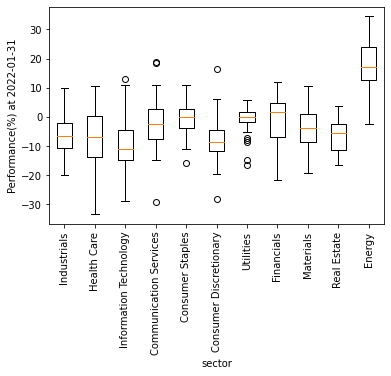

In [ ]:
first_table = first_table[~first_table["Symbol"].isin(tickers_to_ignore)]

industry_list = list(first_table['GICS Sector'].unique())
performance_by_industry = [data_1.loc[:,first_table[first_table["GICS Sector"] == x]["Symbol"]].values[0] for x in industry_list]
plt.boxplot(performance_by_industry, labels = industry_list)
plt.xticks(rotation=90)
plt.xlabel('sector')
plt.ylabel(f"Performance(%) at {end_day}")
plt.show()

When looking at sectors, you can see that performance is not good except for the energy sector.

Note, however, that we are looking at the end of Janurary here. If we look at the price movements in the middle of January, we may see a different perspective. 

For example, Tesla stock performed well in the first few days of January, but gradually declined. Apple stock continued to perform poorly, but at the end of January it was back to plus/minus 0. Bristol Myers stock has had a more subdued price movement, but has been a consistent performer.

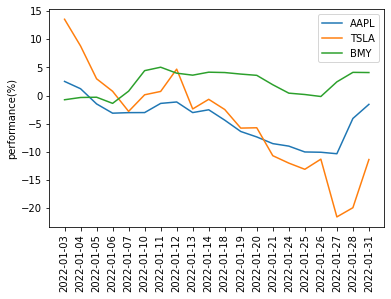

In [ ]:
examples = ["AAPL", "TSLA", "BMY"]
for x in examples:
    plt.plot(data_3[x], label=x)
plt.xticks(rotation=90)
plt.ylabel("performance(%)")
plt.legend(loc="upper right")
plt.show()

### Clustering

#### One Dimensional Data

We will first perform clustering using Type 1 data.

Before clustering, we first check the disribution of the data.

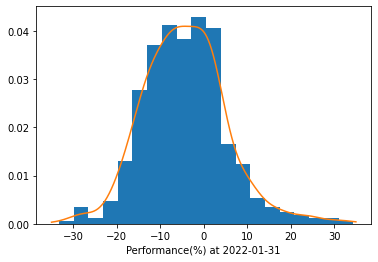

In [ ]:
# kernel density estimation
x = np.linspace(-35, 35, 1000)
kde = gaussian_kde(data_1.values)
y = kde(x)

plt.hist(data_1.loc[end_day, :], bins=20, density=True)
plt.plot(x, y)
plt.xlabel(f"Performance(%) at {end_day}")
plt.show()

We may think that clustering is not necessary because data is nicely distributed around -5 and there is no cluster. But if we attempt to create clusters, we can divide the data with performance greater than and less than 0.

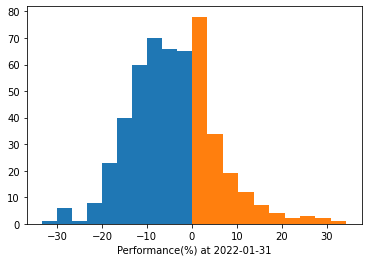

In [ ]:
plt.hist(data_1[data_1 < 0].loc[end_day, :], bins=10)
plt.hist(data_1[data_1 >= 0].loc[end_day, :], bins=10)
plt.xlabel(f"Performance(%) at {end_day}")
plt.show()

Here we will use KMeans clustering to divide the data into three clusters as a test. We could indeed divide them into three, but the boundaries of the clusters are not appropriate.

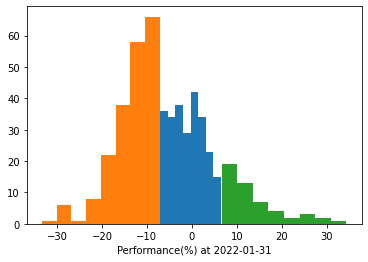

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_1.T.values)
for i in range(n_clusters):
    plt.hist(data_1.loc[end_day, kmeans.labels_ == i], bins = 8)
plt.xlabel(f"Performance(%) at {end_day}")
plt.show()

The boundaries in the above plot are not appropriate.

What if the data is one-dimensional , but with the following distribution, clustering into three dimensions would be appropriate.

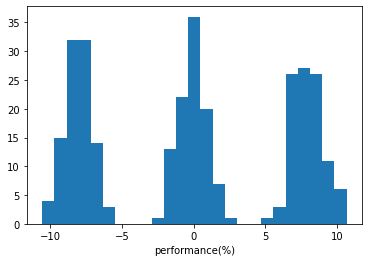

In [ ]:
dummy_zero = np.random.normal(0,1,100)
dummy_minus = np.random.normal(-8,1,100)
dummy_plus = np.random.normal(8,1,100)
dummy = np.concatenate([dummy_zero, dummy_minus, dummy_plus])
plt.hist(dummy, bins=25)
plt.xlabel("performance(%)")
plt.show()

Let's use KMeans again to divide the data into three clusters. This time it should work.

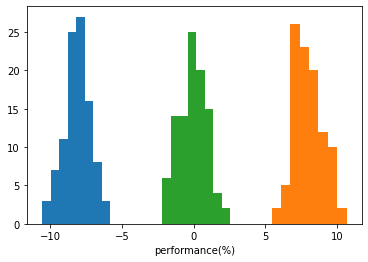

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters,
                random_state = 0).fit(dummy.reshape(-1,1))
for i in range(n_clusters):
    plt.hist(dummy[kmeans.labels_ == i], bins = 8)
plt.xlabel("performance(%)")
plt.show()

### Two Dimensional Data

What if the data is two-dimensional ? The distribution of the data becomes a bit more complex.

Let's check the distribution of type 2 data. 

Note that type 2 data has three dimensions. So we are going to slice the data and plot the two-dimensional data. 

We first plot the performance on January 18th and January 31st.

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot
    ax.scatter(x, y, alpha=0.5)
    # now determine nice limits by hand
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

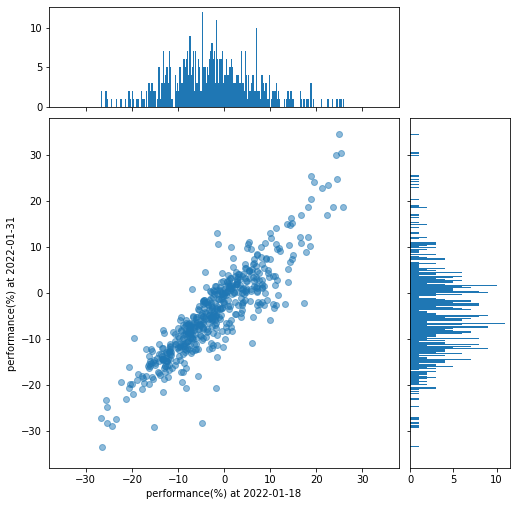

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, width_ratios = (7,2), height_ratios = (2,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex = ax)
ax_histy = fig.add_subplot(gs[1,1], sharey = ax)

scatter_hist(data_2.loc[midterm_day, :], data_2.loc[end_day, :], ax, ax_histx, ax_histy)
ax.set_xlabel(f"performance(%) at {midterm_day}")
ax.set_ylabel(f"performance(%) at {end_day}")
plt.show()

Interestingly there appears to be a strong correlation between performance as of January 18 and January 31. 

Next, we are going to plot performance on January 3rd and January 31.

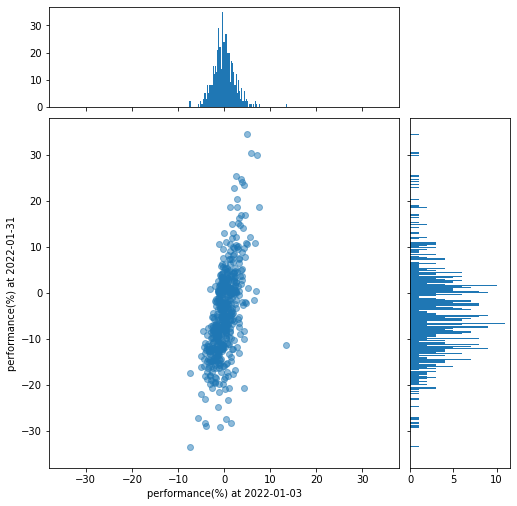

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, width_ratios = (7,2), height_ratios = (2,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex = ax)
ax_histy = fig.add_subplot(gs[1,1], sharey = ax)

scatter_hist(data_2.loc[start_day, :], data_2.loc[end_day, :], ax, ax_histx, ax_histy)
ax.set_xlabel(f"performance(%) at {start_day}")
ax.set_ylabel(f"performance(%) at {end_day}")
plt.show()

Both days have a mountainous distribution, but the width is wider on January 31 than on January 3, indicating greater volatility. 

Here we cluster using the data from January 18 and January 31, lets use KMeans again to divide the data into three clusters.

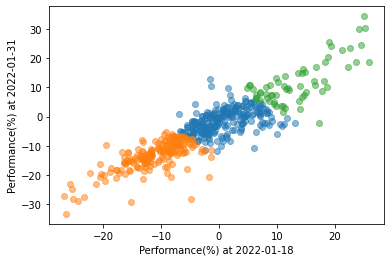

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_2.T.values)
for i in range(n_clusters):
    plt.scatter(data_2.loc[midterm_day, kmeans.labels_ == i], data_2.loc[end_day, kmeans.labels_ == i], alpha = 0.5)
plt.xlabel(f"Performance(%) at {midterm_day}")
plt.ylabel(f"Performance(%) at {end_day}")
plt.show()

Again, there do not appear to be clear cluster boundaries.

So, we will try another clustering method.

First , we will hierarchical clustering. With hierarchical clustering, a reasonable threshold and number of clusters can be determined later by looking at the tree diagram.

### Three Dimensional Data

We will try clustering using all of the Type 2 data, including the January 3 data.

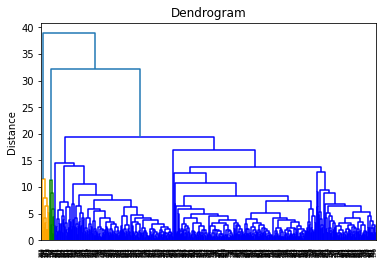

In [ ]:
result = linkage(data_2.T.values,  # linkage imported from scipy.cluster.hierarchy
                 metric='euclidean', method='average')
color_list = ['orange', 'green', 'blue', 'pink']
set_link_color_palette(color_list)
dendrogram(result)
plt.title("Dendrogram")
plt.ylabel("Distance")
plt.show()

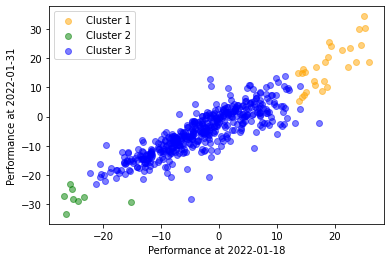

In [ ]:
labels = fcluster(result, t=20, criterion="distance")  # fcluster imported from scipy.cluster.hierarchy
for i, x in enumerate(set(labels)):
    plt.scatter(data_2.loc[midterm_day, labels == x],
                data_2.loc[end_day, labels == x],
                alpha = 0.5, color = color_list[i], label = f"Cluster {x}")
    
plt.xlabel(f"Performance at {midterm_day}")
plt.ylabel(f"Performance at {end_day}")
plt.legend()
plt.show()

With hierarchical clustering, the clusters appear to be more neatly divided than before.

The cluster 1 performed very well on both days. Let's check what stocks are included in this cluster. 

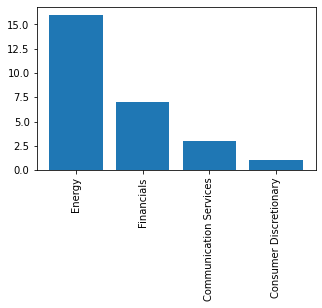

In [ ]:
cluster_1 = data_2.loc[:, labels == 1].columns
sector_counts = first_table[first_table["Symbol"].isin(cluster_1)]["GICS Sector"].value_counts()
sectors = sector_counts.index
plt.figure(figsize=(5,3))
plt.bar(sectors, sector_counts)
plt.xticks(rotation=90)
plt.show()

The energy sector dominated majority of Cluster 1 , with the financial sector the second most common.

The breakdown of Cluster 2 shows that , in constrast to Cluster 1, the Technology, Healthcare and Industrials made up the majority of stocks. The financial sector was rather more prevalent in cluster 2.

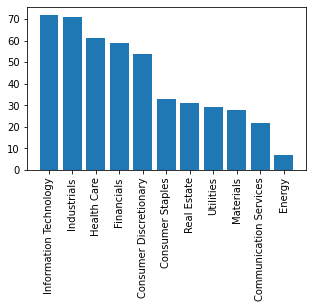

In [ ]:
cluster_2 = data_2.loc[:, labels == 3].columns

sector_counts = first_table[first_table["Symbol"].isin(cluster_2)]["GICS Sector"].value_counts()
sectors = sector_counts.index
plt.figure(figsize=(5,3))
plt.bar(sectors, sector_counts)
plt.xticks(rotation=90)
plt.show()

If we recall the distribution of one-dimensional dummy data, where the data was distributed around three centroids. Let's examine the centroid of each cluster.

In [ ]:
centroids_list = []
for x in set(labels):
    centroid = data_2.loc[:, labels == x].mean(axis=1)
    centroid = pd.DataFrame(centroid, columns=[x])
    centroids_list.append(centroid)
centroids_df = pd.concat(centroids_list, axis=1)
print("Centroids of each cluster")
display(centroids_df)

Centroids of each cluster


,1,2,3
Date,,,
2022-01-03,4.127434,-2.769184,0.007318
2022-01-18,22.351215,-24.094692,-2.546110
2022-01-31,23.742128,-27.751196,-4.714443


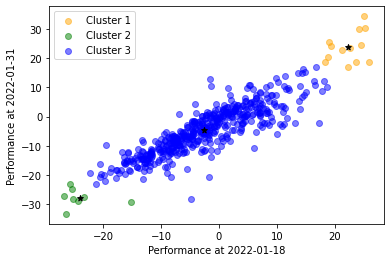

In [ ]:
labels = fcluster(result, t=20, criterion="distance")
for i, x in enumerate(set(labels)):
    plt.scatter(data_2.loc[midterm_day, labels == x], data_2.loc[end_day, labels == x],
                alpha = 0.5, color = color_list[i], label=f"Cluster {x}")
    plt.scatter(centroids_df.loc[midterm_day, x],
                centroids_df.loc[end_day, x], color='black', marker="*")

plt.xlabel(f"Performance at {midterm_day}")
plt.ylabel(f"Performance at {end_day}")
plt.legend()
plt.show()

Looking at the centroid of cluster 2, we can see that this is the group that performed very poorly on all the days we specified. Cluster 3 performed poorly as well, but better than cluster 2. Cluster 3 performed the best on all the three days.

### 20 Dimensional Data

What if the data had 20 dimensions? The ditribution of the data becomes quite complex and cannot be easily illustrated. Dimensionality reduction is effective here. Let's use one of the dimensionality reduction methods, tSNE, to compress to two dimensions. 

In [ ]:
data_3.shape

(20, 502)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(502, 2)


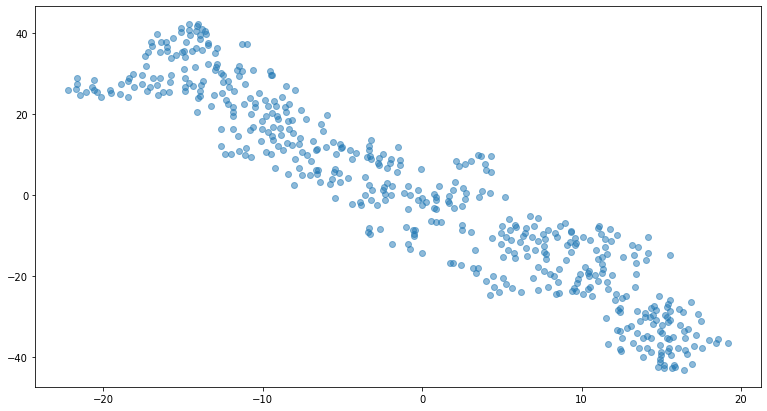

In [ ]:
tsne = TSNE(n_components=2, random_state=41)
X_reduced = tsne.fit_transform(data_3.T)
print(X_reduced.shape)

plt.figure(figsize=(13,7))
plt.scatter(X_reduced[:,0], X_reduced[:, 1], alpha=0.5)
plt.show()

How many clusters do you think would be good to divide into when you look at the graph above? Dimensionality reduction is not always accurate, but it does provide useful information in clustering.

Let's look at how the three clusters obtained from the clustering of the 3D data earlier are distributed in the 2D plot of tSNE.

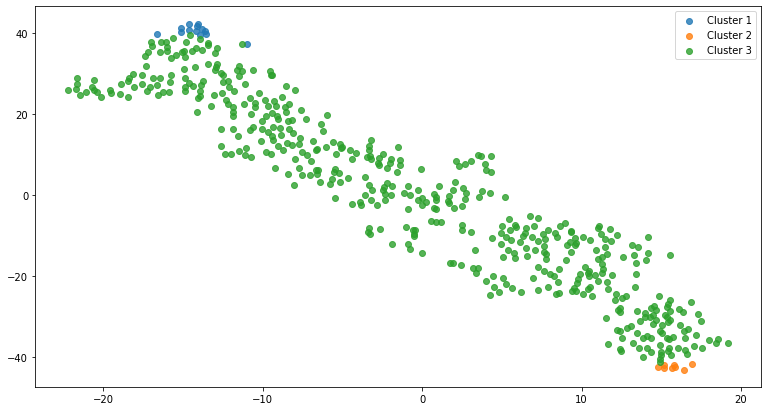

In [ ]:
plt.figure(figsize=(13,7))
for x in set(labels):
    plt.scatter(X_reduced[labels==x, 0], X_reduced[labels==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

Clusters 1 and 2 are distributed in similar positions, which is a favorable result, and the dimensionality reduction by tSNE seems to be working well.
However, cluster 3 has a wider distribution and may need to be clustered more finely. 

Since tSNE is working well, we finally perform clustering on this two-dimensional data using **DBSCAN (Density Based Spatial Clustering of Applications with Noise)**.

DBSCAN is an algorithm for density-compliant clustering. The number of points within a radius determines the region as a cluster. As long as the density of the neighborhood exceeds a certain threshold, the cluster continues to grow. Points with no neighboring points within the radius are noise (cluster 1).

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}


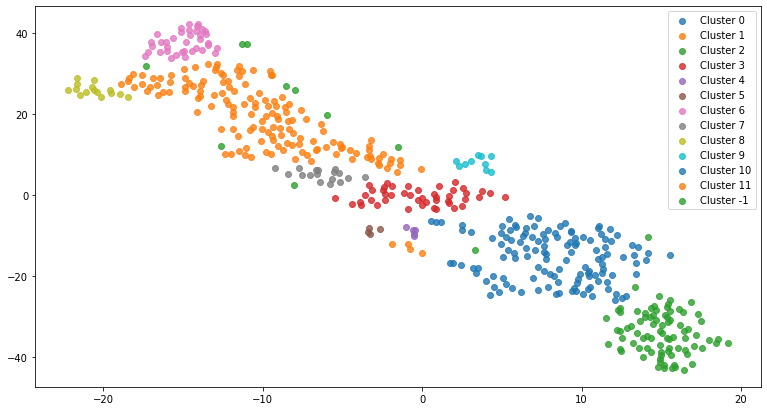

In [ ]:
clustering = DBSCAN(eps=1.7, min_samples=3).fit(X_reduced)
labels_dbscan = clustering.labels_
print(set(labels_dbscan))

plt.figure(figsize=(13,7))
for x in set(labels_dbscan):
    plt.scatter(X_reduced[labels_dbscan==x, 0], X_reduced[labels_dbscan==x, 1], alpha=0.8, label=f"Cluster {x}")
plt.legend()
plt.show()

Lets check the centroids of the each cluster. Note that the cluster -1 meant to be noise. 

Centroids of each cluster.


,0,1,2,3,4,5,6,7,8,9,10,11,-1
Date,,,,,,,,,,,,,
2022-01-03,-1.045082,0.542420,-2.105386,-0.079267,1.519370,3.546804,3.596942,0.787894,2.945580,0.845775,0.292370,4.722768,1.224696
2022-01-18,-7.726986,3.280511,-15.649851,-2.841357,-2.601932,-2.972700,16.360374,-0.611338,9.544608,2.991641,-3.105353,-1.478669,0.970818
2022-01-31,-9.905207,2.162848,-16.861439,-4.460046,-6.116296,-7.950473,14.803899,-2.326959,-2.426065,-5.711424,-9.417053,-14.401721,2.643194


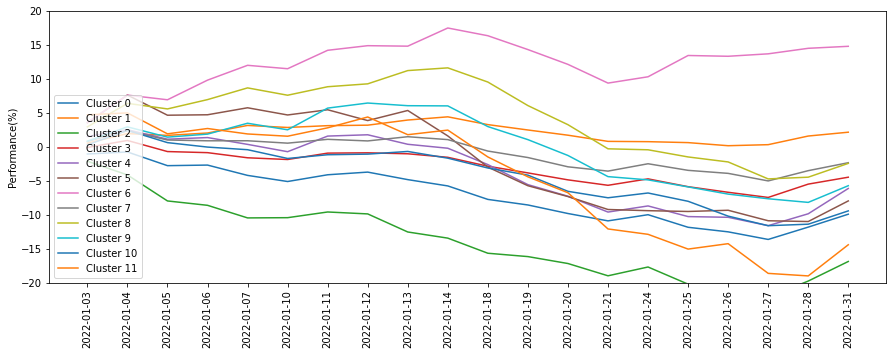

In [88]:
centroids_list = []
for x in set(labels_dbscan):
    centroid = data_3.loc[:, labels_dbscan == x].mean(axis=1)
    centroid = pd.DataFrame(centroid, columns=[x])
    centroids_list.append(centroid)

centroids_df = pd.concat(centroids_list, axis=1)
print("Centroids of each cluster.")
# For ease of thinking, only 3 days are shown.
display(centroids_df.loc[[start_day, midterm_day, end_day], :])

plt.figure(figsize=(15,5))
for x in range(12):
    plt.plot(centroids_df.loc[:,x], label=f"Cluster {x}")
plt.legend()
plt.xticks(rotation=90)
plt.legend(loc="lower left")
plt.ylim(-20, 20)
plt.ylabel("Performance(%)")
plt.show()

The cluster number in order of best performance are 6, 8 and 1. This is consistent with the distribution of each cluster in the two dimensional plot above. 

Finally, we plot all the data belonging to each cluster. The figure below shows that the clusters are well separated.

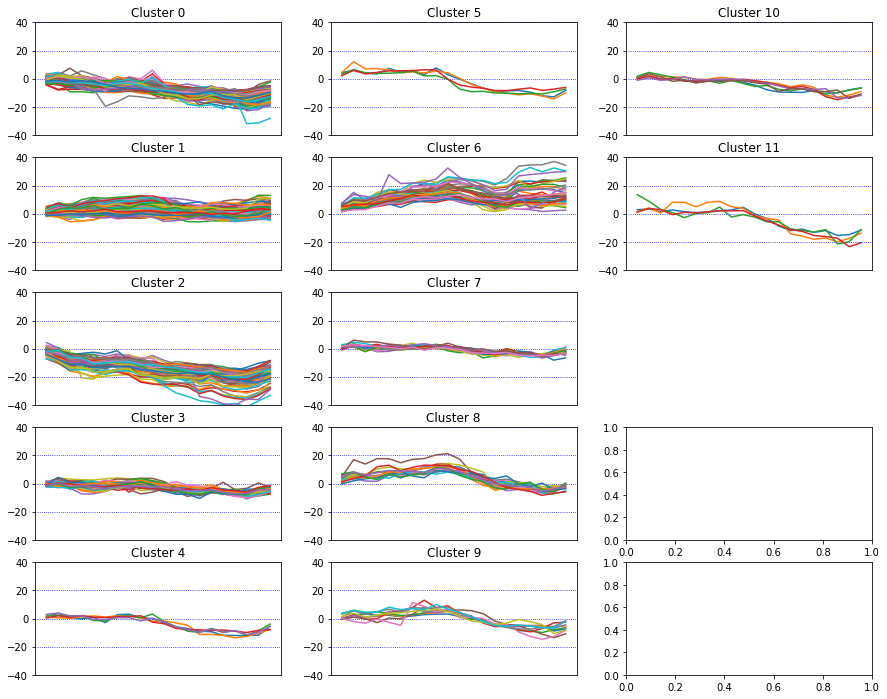

In [104]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,12))
for i, x in enumerate(set(labels_dbscan)):
    ax = axes[i%5][i//5]
    if x == -1:
        ax.axis('off')
        continue
    ax.plot(data_3.loc[:, labels_dbscan==x])
    ax.set_title(f"Cluster {x}")
    ax.set_ylim(-40, 40)
    ax.get_xaxis().set_visible(False)
    ax.grid(axis='y', linestyle='dotted', color='b')

We will sample three representative stocks from each cluster. Buying stocks in Cluster 6 was a wise investment. 


In [106]:
for x in set(labels_dbscan):
    if x == -1:
        continue
    print(f"Cluster {x}")
    print(list(data_3.loc[:, labels_dbscan==x].T.sample(3).index))

Cluster 0
['MTCH', 'GOOGL', 'ADP']
Cluster 1
['MCK', 'PCG', 'HII']
Cluster 2
['IT', 'KMX', 'TRMB']
Cluster 3
['IPG', 'CF', 'UPS']
Cluster 4
['QCOM', 'SWKS', 'SPG']
Cluster 5
['GM', 'GS', 'JPM']
Cluster 6
['GPN', 'TFC', 'DE']
Cluster 7
['WAB', 'TDG', 'ZBH']
Cluster 8
['HBAN', 'F', 'BWA']
Cluster 9
['SYF', 'IVZ', 'CE']
Cluster 10
['FRT', 'TEL', 'VFC']
Cluster 11
['SIVB', 'WDC', 'TSLA']


### Conclusion

It is important to check the distribution of the data and confirm that the data is actually divided into clusters. Also understanding of the parameters such as threshold, number of clusters and metric is important. 
Understanding the characteristics of the clustering methods and the distribution of the data will lead to successful clustering. 